# Navigation Report

---

The following project was done as part of the Udacity's Deep Reinforcement Learning Nanodegree.
The starting code and environment was collected from them. The environment is set in where you move around and try to collect as many yellow bananas as you can and avoid the blue ones.

I have design neural network model and have trained that learns to navigate through the world, and take yellow  avoiding blue ones.

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip install ./python

Processing c:\workspace\p1_navigation\python


  Could not find a version that satisfies the requirement torch==0.4.0 (from unityagents==0.4.0) (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2)
No matching distribution found for torch==0.4.0 (from unityagents==0.4.0)
You are using pip version 9.0.1, however version 20.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


During training I used the workspace provided by Udacity, but if you use it locally you can update the path for it.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
# env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


Importing modules for building and training the neural network.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import namedtuple, deque
from matplotlib import pyplot as plt

Identify device, on workspace I used their provided GPU, but when locally it will pick the CPU

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Network Strucutre
After several trial and errors I ended up keeping the following neural network architeture for this problem. The following has seven hidden layers. Each hidden layers uses ReLu activation.

In [7]:
class Network(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(Network, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.first = nn.Linear(state_size, 64)
        self.layer1 = nn.Linear(64, 64)
        self.last = nn.Linear(64, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.first(state))
        x = F.relu(self.layer1(x))
        return self.last(x)

##### Hyperparameters, Learning Algorithm

The following code was mainly brought from the dqn_agent.py file from a previous practice project in the nanodegree. It has the code for Agent and ReplayBuffer class. ReplayBuffer class allows to train the model using Experience Replay. It keeps in memory previous 100 thousand steps and trains the model using a batch size of 64.

I only updated the learning rate and tau that is used to update the target parameters. As I did trial and error I noticed that the lower rate and tau made the progression slow, but by increase these the the agent achieved an average score above 13 much earlier.

Alongside experience replay agent also learns using fixed q target, so having a lightly higher tau keeps the target changing a bit more rapidly.

The agent also used epsilon greedy approach to picking actions, to allow the agent to explore the states instead of focusing on exploiting from the get go. Especially for this time of environment, I believe exploration is quite important. With low epsilon it can end up in situations where the agent gets stuck at a point, where it will keep turning and moving back and forth as just movements give no reward. So for example if a blue banana stays ahead the agent might end up getting stuck their moving back and forth or turning left and right, but having high exploration will make it try new things on learning and on the longer run help it become better at performing its task.

The learning algorithm takes the batch of experiences and uses the the target network to determine the state-action value pair for the taken actions using the local qnetwork model. It calculates a value Q-value for next states and then uses `rewards + (gamma * Q_next_states * (1 - dones))` to get current states Q-value. Which is then taken to compare with Q-value determined the local network. Using mean square error loss (mse_loss) it the difference between target and local Q-value is determined and performs gradient descent on the local model based on that. And afterwards it does a soft update of the target Q network, affecting a small change for the changes in local model.

Once again the base code for all of the above was obtained from the workspace, I only played with the hyperparameters to bring better performance in the agent.

In [12]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-2              # for soft update of target parameters
LR = 1e-4               # learning rate 
UPDATE_EVERY = 5        # how often to update the network


class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = Network(state_size, action_size, seed).to(device)
        self.qnetwork_target = Network(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        
        # If enough samples are available in memory, get random subset and learn
        if len(self.memory) > BATCH_SIZE and self.t_step == 0:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            action = np.argmax(action_values.cpu().data.numpy())
        else:
            action = random.choice(np.arange(self.action_size))
            
        return action
            

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
#         print(actions)
        Q_expected = self.qnetwork_local(states).gather(1, actions)
#         print(self.qnetwork_local(states).shape, Q_expected.shape, Q_targets.shape)
        
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.t_step == 0:
            # ------------------- update target network ------------------- #
            self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [13]:
agent = Agent(state_size, action_size, 0)

#### Learning Iteration

The following function is the training block for the agent. This is also brought from the previous practice project in the nanodegree program, but slightly changed. I updated to keep a frequent checkpoint and updated the eps decay rate, so that the learning hopes to explore for around first 1500 episodes. The code also saves an optimum model which outperforms all the epsiodes in training. Although this wouldn't be very reliable as it is not guarnated the model caused better performance or was it just lucky on its random picks. But even so the pick on general should push the model in a positive direction.

As mentioned before it uses epsilon greedy approach to pick an action. Once it takes the action it invokes the step in the environmenet collecting the new state details along with reward and done status. It then adds that step to agent, where the agent will invoke the learning algorithm at every few steps to updat its local network model and target network model.

In [14]:
def dqn(n_episodes=2000, max_t=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.9969, train=True):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train (bool): to update agent or not
    """
    max_score = -100
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    print("Starting training")
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = int(agent.act(state, eps))
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]   
            if train:
                agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                if train:
                    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_done.pth')
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}, Max score: {}, Min score: {}'.format(i_episode, np.mean(scores_window), np.max(scores_window), np.min(scores_window)), end="")
        if train:
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(), f'checkpoint.pth')
            if np.mean(scores_window) > 13:
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_solution.pth')
                print(f'Solution score {score} obtained at {i_episode}' )
                break
    #         torch.save(anget.qnetwork_local.state_dict(), f'checkpoint{i_episode}.pth')
    return scores

Starting training
Episode 100	Average Score: 0.40, Max score: 5.0, Min score: -4.0
Episode 200	Average Score: 2.99, Max score: 8.0, Min score: -1.0
Episode 300	Average Score: 5.24, Max score: 15.0, Min score: -1.0
Episode 400	Average Score: 6.50, Max score: 16.0, Min score: -1.0
Episode 500	Average Score: 7.81, Max score: 16.0, Min score: -2.0
Episode 600	Average Score: 10.27, Max score: 19.0, Min score: 3.0
Episode 700	Average Score: 11.55, Max score: 20.0, Min score: 2.0
Episode 800	Average Score: 12.15, Max score: 20.0, Min score: 4.0
Episode 847	Average Score: 13.03, Max score: 19.0, Min score: 4.0Solution score 15.0 obtained at 847


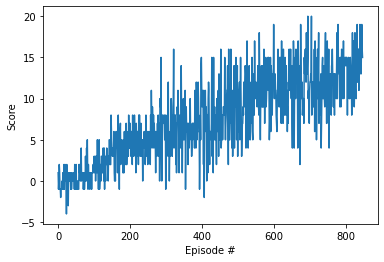

In [15]:
# agent.qnetwork_local.load_state_dict(torch.load("checkpoint.pth"))
scores = dqn(n_episodes=1800)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Performance
Above you can see the model get average score of 13+ by 1200 episodes, having a higher learning rate and tau helped it to acheive that score much faster but also due to that the variation is much higher.

This is why below I do a quick comparison over 100 episodes for the three different checkpoints I have saved. One is the checkpoint that is updated every time agent gets into the terminal state of the environment. One is checkpoint for every step, so it is the final state, and the other is the optimum checkpoint, which saves whenever the highest score increases.

And as we can see this gave the highest average score.

In [ ]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_done.pth', map_location='cpu'))
scores = dqn(100, 1000, 0,0,0, False)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth', map_location='cpu'))
scores = dqn(100, 1000, 0,0,0, False)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_opt.pth', map_location='cpu'))
scores = dqn(100, 1000, 0,0,0, False)

Running the environment with optimum model to visually see its performance.

In [ ]:
agent.qnetwork_local.load_state_dict(torch.load('model.pth', map_location='cpu'))
env_info = env.reset(train_mode=False)[brain_name]
state = torch.from_numpy(env_info.vector_observations[0]).float().unsqueeze(0)
score = 0
blue_ban = 0
yellow_ban = 0
moves = 0
for i in range(10000):
    action = np.argmax(agent.qnetwork_local(state).cpu().data.numpy())
    env_info = env.step(int(action))[brain_name]
    next_state = torch.from_numpy(env_info.vector_observations[0]).float().unsqueeze(0)
    reward = env_info.rewards[0]
    if reward > 0:
        yellow_ban += 1
    elif reward < 0:
        blue_ban += 1
    
    done = env_info.local_done[0]
    state = next_state
    if done:
        print("Marked done")
        break
    score += reward
print("Final score", score)
print(blue_ban, yellow_ban)

#### Problems and Improvment

While the goal of the project is obtained there are multiple places to improve. To begin with there could have been significant improvement if I made use of better alogrithms like Double DQN, Duelling DQN or Prioritized Experience Replay.

A common problem identified is that it does try to avoid the blue bananas but it still according to me at cases fails to achieve something even higher. For example in some cases maybe going pass a blue banana would result in getting more yellow bananas resulting and overall higher score. Or in some cases it just keeps going forward where there is nothing ahead. Sometimes it would get on the walls as well. It was suggested in my feedback that these overfitting problems could have been reduced by adapting regularization techniques such as L2 or Dropout.

The agent mostly chooses to go to its nearest yellow banana avoiding the blue ones direction in most cases, but in certain cases it could be that going through the blue banana would end up resulting it to get even more yellow bananas. While discount rate during training I used was already high, but it could posibly been improved if we did Prioritized Experience Replay. As it would work more on the TD errors.

For reducing the moves toward an empty area, we could introduce a small penalty for moves where you dont collect anything. This could help the agent to learn to pick more bananas in fewer steps. But another thing that could help is using Double DQN as it helps avoid overestimation of the Q-value.

Another point mentioned in my project feeback was that the network architecture was a bit of an overkill. A much smaller network could possibly have obtained the same achievement in a bit more episodes, and on the long run this is something that would be more preferable compared to a large network. Which is indeed true, as shared before the large network ends up sort of overfitting. While it achieves the goal, the performance can't really be marked as the optimum performance. Exploring other algorithms could have helped improve the performance much better.

In [ ]:
env.close()